In [1]:
import re
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#my_data = open("data200.json", "r")
data = pd.read_json (r'C:\Flatiron\course-material\ModuleOneFinalProject\dsc-mod-1-project-v2-1-onl01-dtsc-pt-030220\data_0422_0503PM.json')
df = df = pd.DataFrame(data)
# df.info()
print(df.shape)
#df.describe()
df[1465:1470]


(3413, 20)


,Title_id,Budget,Gross USA,Cumulative Worldwide Gross,Opening Weekend USA,Title,Year,Popularity,Genre,Runtime_min,Release_day,IMDB_Rate,Rating_count,Meta_Score,Director,Writer,Star,User_Review_Number,Critical_Review_Number,Meta_Rating
1465,tt6946468,60000,NaN,NaN,NaN,Viscera,2019,None,"[Crime, Drama]",133.0,11/23/2019,8.5,20.0,NaN,[Anthony Spadaccini],[Anthony Spadaccini],"[Dominic Kates, Cody Kilpatrick Steele, Aimee ...",NaN,NaN,2h 13min
1466,tt10388676,None,NaN,NaN,NaN,Pool Party '15,2019,None,"[Comedy, Drama]",62.0,NaN,NaN,NaN,NaN,"[Logan Garrity, Kevin Greenwood]","[Logan Garrity, Kevin Greenwood]","[Michael St. Germain, Amadi Houston, Jasmine D...",NaN,NaN,1h 2min
1467,tt11871490,800,NaN,NaN,NaN,Loretta 2 New Beginning,2019,None,"[Comedy, Drama, Romance, Thriller]",82.0,09/12/2019,NaN,NaN,NaN,[Anthony Dye],[Anthony Dye],"[Pamela Holmes, Jason Russell, Peighton Bryant]",NaN,NaN,1h 22min
1468,tt9793446,None,NaN,NaN,NaN,The Lioness,2019,None,[Thriller],48.0,02/21/2019,NaN,NaN,NaN,[Richard Poche],"[Vicky L. Neal, Richard Poche]","[Giuliana Gutierrez, Lacy Hartselle, Desi Ivan...",NaN,NaN,48min
1469,tt8841972,200000,NaN,NaN,NaN,The Blackout,2019,None,"[Drama, Thriller]",120.0,11/06/2019,NaN,NaN,NaN,"[Charles Kassatly, Rico Shay]","[Rico Shay, Charles Kassatly]","[Derrick Mckenzie, Roger Azar, Charles Kassatly]",NaN,NaN,2h


In [60]:
#print(df['Budget'])
#df.isna().sum()
#df = df.replace({'None': None})
#df.tail()

In [63]:
int_columns = ['Budget','Gross USA','Cumulative Worldwide Gross', 'Popularity',
               'Opening Weekend USA','Opening Weekend USA',
               'IMDB_Rate','Rating_count', 'Meta_Score','User_Review_Number',
              'Critical_Review_Number']
for column in int_columns:
    df[column] = pd.to_numeric(df[column],errors='coerce')

    # df['Budget:'] = df['Budget:'].astype(int)
#type(df['Budget:'][0])
#df.info()



mean      6.876761e+06
median    4.000000e+04
std       2.804416e+07
Name: Budget, dtype: float64

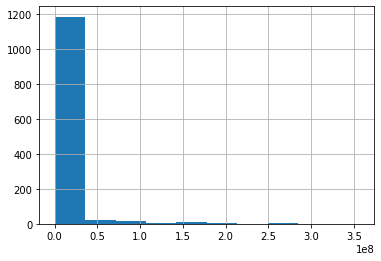

In [66]:
non_miss_Budegets = df['Budget'].loc[df['Budget'] > 0]
#print(non_miss_Budegets)
non_miss_Budegets.isna().sum()
display(non_miss_Budegets.apply(['mean', 'median', 'std']))
non_miss_Budegets.hist()

In [132]:
df['Genre']
# All_Genres = []
# Title_id_New = []
# Budget_New = [] 
# Gross_New = []
# Worldwide_Gross_New = []
# Opening_Weekend_New = []
# df['Title_id']
# len(df['Genre'][0])

#def creat_genre_df(col_name):
Genres = []
Title_id = []
col_name = [] 
for index, genres in enumerate(df['Genre']):
     if(isinstance(genres, list)):
        for genre in genres:
            Genres.append(genre)
            Title_id.append(df['Title_id'][index])
            col_name.append(df[col_name][index])
            print(col_name)
# genres_dic = {'Title_id':Title_id, 'Genres': Genres, col_name: col_name }
# genres_df = pd.DataFrame(genres_dic)
#return(genres_df)
#creat_genre_df(Budget)
#print(All_Genres, Title_id_New, Gross_New, Worldwide_Gross_New, Opening_Weekend_New )   


# for index, genres in enumerate(df['Genre']):
#     #print(len(genres))
#     #print(genres)
#     if (isinstance(genres, list)):
#         for genre in genres:
#             All_Genres.append(genre)
#             Title_id_New.append(df['Title_id'][index])
#             Budget_New.append(df['Budget'][index])
#             Gross_New.append(df['Gross USA'][index])
#             Worldwide_Gross_New.append(df['Cumulative Worldwide Gross'][index])
#             Opening_Weekend_New.append(df['Opening Weekend USA'][index])
# #print(All_Genres, Title_id_New, Gross_New, Worldwide_Gross_New, Opening_Weekend_New )   


KeyError: 0

In [12]:
genres_dic = {'Title_id':Title_id_New, 'Genres': All_Genres, 'Budget': Budget_New,
              'Gross_USA': Gross_New, 'Worldwide_Gross': Worldwide_Gross_New,
             'Opening_Weekend':Opening_Weekend_New }

genres_df = pd.DataFrame(genres_dic)
genres_df.shape

(5677, 6)

In [124]:
unique_genres = set(All_Genres)
#print(unique_genres)
import collections
total_rows =len(All_Genres)
genre_country = collections.Counter(All_Genres)
print(genre_country)
def get_genre_weight(genre, Genres_column):
    genre_country = collections.Counter(Genres_column)
    return(genre_country[genre]/total_rows)
genre_weight('Action', All_Genres)

Counter({'Drama': 1370, 'Comedy': 803, 'Thriller': 653, 'Horror': 617, 'Action': 363, 'Crime': 244, 'Romance': 226, 'Sci-Fi': 212, 'Mystery': 208, 'Adventure': 181, 'Family': 154, 'Fantasy': 141, 'Animation': 132, 'Music': 93, 'Biography': 65, 'Sport': 52, 'History': 46, 'Musical': 37, 'Western': 33, 'War': 31, 'Reality-TV': 6, 'News': 5, 'Talk-Show': 5})


0.06394222300510834

In [126]:
genre_weight = {}
for genre in genre_country:
#     print(genre)
    genre_weight[genre] = get_genre_weight (genre)
#     print(genre_weight)
print(sum(genre_weight.values()))
genre_weight

1.0


{'Action': 0.06394222300510834,
 'Comedy': 0.1414479478597851,
 'Crime': 0.04298044741941166,
 'Drama': 0.2413246432975163,
 'Mystery': 0.03663906993130175,
 'Thriller': 0.11502554165932712,
 'War': 0.0054606306147613175,
 'Romance': 0.0398097586753567,
 'Adventure': 0.031883036815219305,
 'Fantasy': 0.02483706182843051,
 'Sci-Fi': 0.037343667429980625,
 'Family': 0.027127003699136867,
 'Horror': 0.10868416417121719,
 'Music': 0.016381891844283954,
 'Musical': 0.006517526862779637,
 'Biography': 0.011449709353531795,
 'Sport': 0.009159767482825437,
 'Animation': 0.023251717456403028,
 'History': 0.008102871234807116,
 'Western': 0.005812929364100757,
 'News': 0.0008807468733485996,
 'Reality-TV': 0.0010568962480183195,
 'Talk-Show': 0.0008807468733485996}

In [117]:
def remove_outlier(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
    return df_out

In [122]:
no_outlier_df = remove_outlier(genres_df, 'Budget')
a = no_outlier_df.loc[no_outlier_df['Budget'] > 0 ].groupby('Genres').agg({'Budget': ['mean', 'median']})
print(type(a))
# genres_df.loc[genres_df['Gross_USA'] > 0 ].groupby('Genres').agg({'Gross_USA': ['mean', 'median']})
# genres_df.loc[genres_df['Worldwide_Gross'] > 0 ].groupby('Genres').agg({'Worldwide_Gross': ['mean', 'median']})
# genres_df.loc[genres_df['Opening_Weekend'] > 0 ].groupby('Genres').agg({'Opening_Weekend': ['mean', 'median']})
#no_missing_Budeget.mean()

<class 'pandas.core.frame.DataFrame'>


In [71]:
# data_genres_df = pd.melt(genres_df, id_vars=['Genres'],value_vars=['Budget'],var_name='Gross')
# sns.boxplot(x='Genres',y='value',data=data_genres_df,hue='Gross')

In [42]:
genres_df.groupby('Genres').mean()

,Budget,Gross_USA,Worldwide_Gross,Opening_Weekend
Genres,,,,
Action,2.349300e+07,9.179138e+07,1.656433e+08,3.518171e+07
Adventure,5.616936e+07,1.374690e+08,3.414866e+08,4.704068e+07
Animation,5.712658e+07,1.399289e+08,2.129032e+08,4.295864e+07
Biography,2.175026e+07,2.746804e+07,3.406561e+07,5.793065e+06
Comedy,9.752824e+06,4.633967e+07,8.723043e+07,1.377464e+07
Crime,8.947009e+06,3.393351e+07,4.750549e+07,1.037717e+07
Drama,6.392209e+06,3.254398e+07,5.930339e+07,1.079914e+07
Family,5.347901e+07,1.062567e+08,2.402174e+08,3.365679e+07
Fantasy,4.140937e+07,1.131419e+08,2.579279e+08,3.752951e+07


In [ ]:
# error_list = []
# for i, item in enumerate(df['Budget:']):
#     try:
#         int(item)
#     except ValueError:
#         #error_list.append('ERROR at index {}: {!r}'.format(i, item))
#         error_list.append(i)
# print(error_list)
# len(error_list)
#df = df.drop(error_list, axis=0)

In [ ]:
# curencys = [re.split(r'(\d+)', error) for error in error_list]
# print(curencys)
# curency_used = []
# for curency in curencys:
#     curency_used.append(curency[0])
# uniqe_currency = list(set(curency_used))
# uniqe_currency

In [ ]:
# df = df.replace({'None': None})
# df.head()
# count = 0
# for i, item in enumerate(df['Budget:']):
#     if item == 'None':
# #     if item is None:
#         count += 1
# print(count)

In [135]:
genres_df.head()

,Title_id,Genres,Budget,Gross_USA,Worldwide_Gross,Opening_Weekend
0,tt8367814,Action,22000000.0,36296853.0,114996853.0,10651884.0
1,tt8367814,Comedy,22000000.0,36296853.0,114996853.0,10651884.0
2,tt8367814,Crime,22000000.0,36296853.0,114996853.0,10651884.0
3,tt7131622,Comedy,90000000.0,142502728.0,374343626.0,41082018.0
4,tt7131622,Drama,90000000.0,142502728.0,374343626.0,41082018.0


In [134]:
from scipy import stats
z_scores = stats.zscore(genres_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df[filtered_entries]

TypeError: unsupported operand type(s) for /: 'str' and 'int'